In [20]:
import pandas as pd

In [32]:
preprocess_train_df = pd.read_csv('/kaggle/input/vindrmammo/train_df.csv')
preprocess_train_df['image_path'] = preprocess_train_df['image_path'].str.replace('/kaggle/working', '/kaggle/input/vindrmammo')
preprocess_train_df

,label,image_path
0,1,/kaggle/input/vindrmammo/preprocess/train/1/f9...
1,1,/kaggle/input/vindrmammo/preprocess/train/1/33...
2,1,/kaggle/input/vindrmammo/preprocess/train/1/04...
3,1,/kaggle/input/vindrmammo/preprocess/train/1/4a...
4,1,/kaggle/input/vindrmammo/preprocess/train/1/73...
...,...,...
15994,0,/kaggle/input/vindrmammo/preprocess/train/0/76...
15995,0,/kaggle/input/vindrmammo/preprocess/train/0/ab...
15996,0,/kaggle/input/vindrmammo/preprocess/train/0/bf...
15997,0,/kaggle/input/vindrmammo/preprocess/train/0/36...


In [33]:
aug_label1_df = pd.read_csv('/kaggle/input/vindrmammo/aug_label1_df.csv')
aug_label1_df['image_path'] = aug_label1_df['image_path'].str.replace('/kaggle/working', '/kaggle/input/vindrmammo')
aug_label1_df

,label,image_path
0,1,/kaggle/input/vindrmammo/aug/1/5d2610e24aff460...
1,1,/kaggle/input/vindrmammo/aug/1/5e2abd624c758a9...
2,1,/kaggle/input/vindrmammo/aug/1/baf511682f18f8c...
3,1,/kaggle/input/vindrmammo/aug/1/6873d1aaecb91ad...
4,1,/kaggle/input/vindrmammo/aug/1/85a6579cbdc403c...
...,...,...
9872,1,/kaggle/input/vindrmammo/aug/1/b163d5081f17dcf...
9873,1,/kaggle/input/vindrmammo/aug/1/6770e0804926416...
9874,1,/kaggle/input/vindrmammo/aug/1/9ca728553d6b22d...
9875,1,/kaggle/input/vindrmammo/aug/1/85939e3cfdb707f...


In [34]:
train_df = pd.concat([preprocess_train_df, aug_label1_df]).reset_index(drop=True)
test_df = pd.read_csv('/kaggle/input/vindrmammo/test_df.csv')
test_df['image_path'] = test_df['image_path'].str.replace('/kaggle/working', '/kaggle/input/vindrmammo')
test_df

,label,image_path
0,1,/kaggle/input/vindrmammo/preprocess/test/1/d12...
1,1,/kaggle/input/vindrmammo/preprocess/test/1/4e3...
2,1,/kaggle/input/vindrmammo/preprocess/test/1/767...
3,1,/kaggle/input/vindrmammo/preprocess/test/1/3a6...
4,1,/kaggle/input/vindrmammo/preprocess/test/1/664...
...,...,...
3995,0,/kaggle/input/vindrmammo/preprocess/test/0/6eb...
3996,0,/kaggle/input/vindrmammo/preprocess/test/0/336...
3997,0,/kaggle/input/vindrmammo/preprocess/test/0/21a...
3998,0,/kaggle/input/vindrmammo/preprocess/test/0/61f...


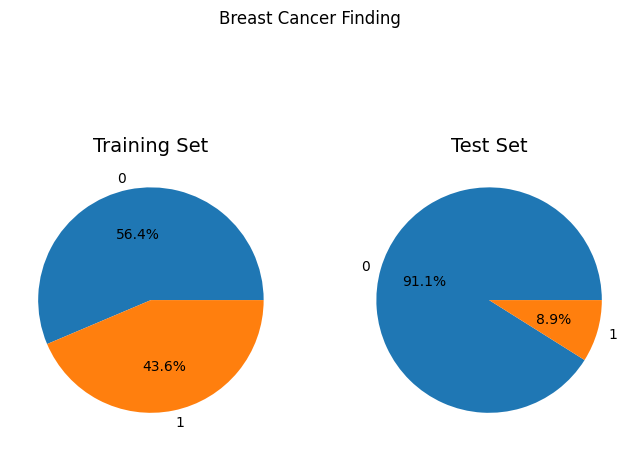

In [35]:
# pathology distributions
value = train_df['label'].value_counts()
fig, axs = plt.subplots(1, 2, figsize=(8, 6))
fig.suptitle('Breast Cancer Finding')
axs[0].pie(value, labels=value.index, autopct='%1.1f%%')
axs[0].set_title('Training Set', fontsize=14)

# pathology distributions
value_1 = test_df['label'].value_counts()
axs[1].pie(value_1, labels=value_1.index, autopct='%1.1f%%')
axs[1].set_title('Test Set', fontsize=14)

plt.show()

## LOAD IMG

In [36]:
from sklearn.utils.class_weight import compute_class_weight

# Assuming y is your label column
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weight_dict = dict(zip(np.unique(train_df['label']), class_weights))

# Convert keys to integers
class_weight_dict = {int(key): value for key, value in class_weight_dict.items()}
class_weight_dict

{0: 0.8868933369893063, 1: 1.1461729270021261}

In [37]:
train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="label",
    target_size=(224, 224), 
    batch_size=64,
    class_mode="categorical",  
    shuffle=True
)

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),  
    batch_size=16,
    class_mode="categorical",  
    shuffle=False  
)

Found 25876 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.


In [ ]:
# Fetch a batch from the generator
sample_batch = train_generator[0]

# Extract the images and labels
combined_images, combined_labels = sample_batch

def reverse_preprocessing(image):
    return (image).astype(np.uint8) 

# Visualize a few sample images
num_samples = min(16, combined_images.shape[0])

plt.figure(figsize=(15, 10))
for i in range(num_samples):
    plt.subplot(4, 4, i + 1)
    plt.imshow(reverse_preprocessing(combined_images[i]))
    plt.title(f'Label: {combined_labels[i]}')
    plt.axis('off')

plt.show()

## TRAIN

In [51]:
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.regularizers import l2

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(2, activation='sigmoid')(x)

# Combine the base model and top layers
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    
model.compile(optimizer=tf.keras.optimizers.experimental.Adam(),
              loss='categorical_crossentropy', 
              metrics=['accuracy', 'AUC'])

In [52]:
def lr_scheduler(epoch):
    lr = 1e-3
    if epoch >= 5:
        lr *= 0.1
    return lr
lr_schedule = LearningRateScheduler(lr_scheduler, verbose=1)

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)

In [53]:
history = model.fit(train_generator, epochs=20, class_weight=class_weight_dict,
                   callbacks=[es, lr_schedule])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
405/405 [==============================] - 86s 198ms/step - loss: 5.3397 - accuracy: 0.8332 - auc: 0.8686 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/20
405/405 [==============================] - 81s 199ms/step - loss: 0.7943 - accuracy: 0.8702 - auc: 0.9212 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/20
405/405 [==============================] - 85s 209ms/step - loss: 0.5823 - accuracy: 0.8714 - auc: 0.9238 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/20
405/405 [==============================] - 78s 193ms/step - loss: 0.6019 - accuracy: 0.8692 - auc: 0.9214 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/20
405/405 [==============================] - 77s 190ms/step - loss: 0.5870 - accuracy: 0.8690 - auc: 0.9205 - lr: 0.0010

Epoch 6: LearningRateSchedule

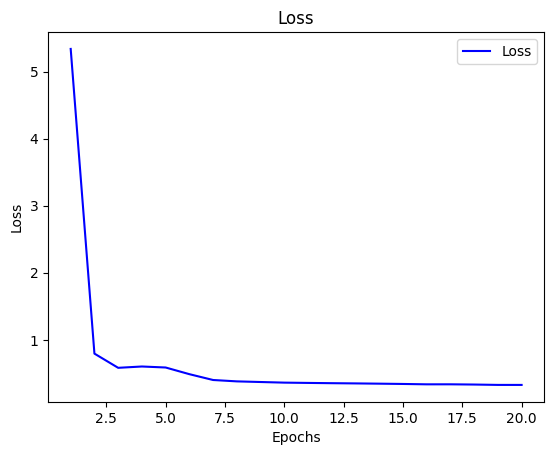

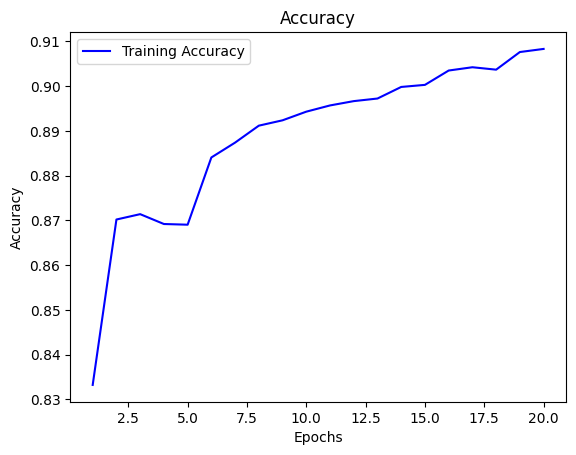

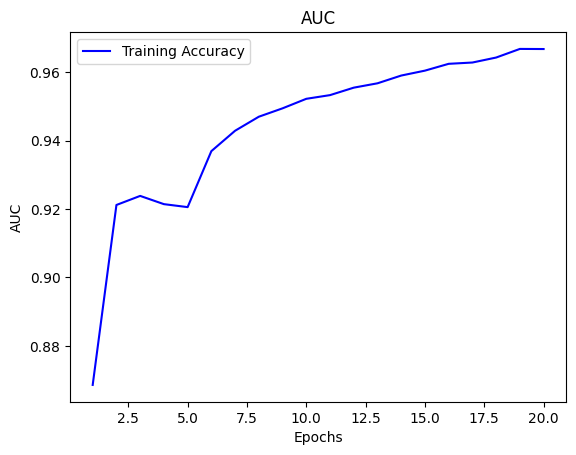

In [54]:
loss_values = history.history['loss']
acc = history.history['accuracy']
auc_train = history.history['auc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss_values, 'b', label='Loss')
plt.title('Loss', fontsize=12)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.title('Accuracy', fontsize=12)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, auc_train, 'b', label='Training Accuracy')
plt.title('AUC', fontsize=12)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [56]:
model.save('/kaggle/working/model.keras')

In [57]:
model.evaluate(test_generator)

250/250 [==============================] - 25s 90ms/step - loss: 0.3979 - accuracy: 0.9000 - auc: 0.9359


[0.39790797233581543, 0.8999999761581421, 0.9358898401260376]

In [68]:
from sklearn.metrics import roc_auc_score

predictions = model.predict(test_generator)
true_labels = test_generator.classes

# Use roc_auc_score to compute AUC over multiple thresholds
roc_auc = roc_auc_score(true_labels, predictions[:, 1])
print(f"AUC: {roc_auc:.4f}")

250/250 [==============================] - 9s 37ms/step
AUC: 0.6737


AUC: 0.6737


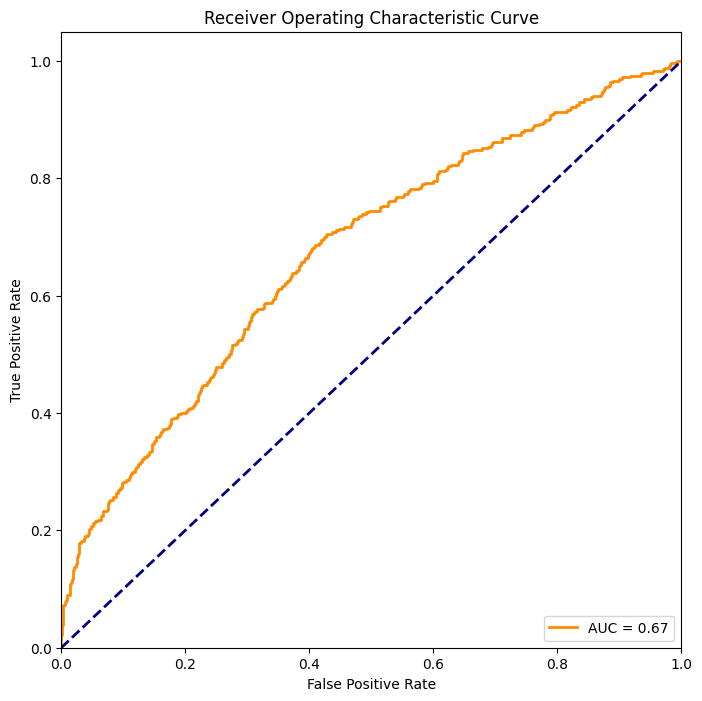

In [69]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# predictions = model.predict(test_generator) 
# true_labels = test_generator.classes
fpr, tpr, thresholds = roc_curve(true_labels, predictions[:, 1])

roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

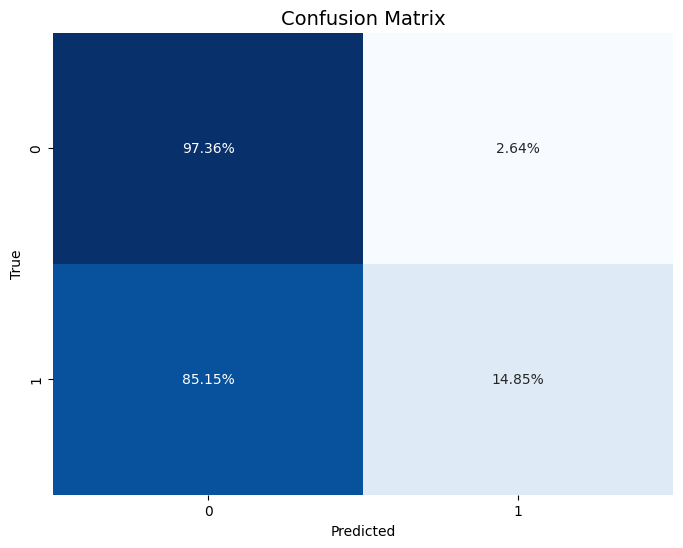

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      3643
           1       0.36      0.15      0.21       357

    accuracy                           0.90      4000
   macro avg       0.64      0.56      0.58      4000
weighted avg       0.87      0.90      0.88      4000



In [70]:
from sklearn.metrics import classification_report, confusion_matrix

# create function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    """plots a normalized confusion matrix as a heatmap."""
    # Calculate row sums
    row_sums = cm.sum(axis=1, keepdims=True)
    # Normalize confusion matrix
    normalized_cm = cm / row_sums

    plt.figure(figsize=(8, 6))
    sns.heatmap(normalized_cm, annot=True, fmt='.2%', cmap='Blues', cbar=False)
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

true_labels = test_generator.classes
# Convert predicted probabilities to predicted labels (0 or 1)
predicted_labels = np.argmax(predictions, axis=1)

# Confusion matrix as percentage 
cm = confusion_matrix(true_labels, predicted_labels)
plot_confusion_matrix(cm=cm, title='Confusion Matrix')

# Classification report
print(classification_report(true_labels, predicted_labels, target_names=list(test_generator.class_indices.keys())))